In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import rasterio
from sklearn.model_selection import train_test_split
import os
from tqdm import tqdm

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.15 (you have 1.4.11). Upgrade using: pip install --upgrade albumentations


In [2]:
class SegmentationDataset(Dataset):
    def __init__(self, image_paths, label_paths, transform=None):
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        try:
            with rasterio.open(self.image_paths[idx]) as src:
                image = src.read([1, 2, 3, 4, 5, 6])  # Read all 6 bands
            image = np.transpose(image, (1, 2, 0))  # Change from (bands, height, width) to (height, width, bands)

            with rasterio.open(self.label_paths[idx]) as src:
                label = src.read(1)  # Assuming labels are in the first band

            if self.transform:
                image = self.transform(image=image)['image']  # Apply transformations

            return torch.tensor(image, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

        except Exception as e:
            print(f"Error loading sample at index {idx}: {str(e)}")
            return None, None


def get_all_file_paths(directory):
    file_paths = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".tif") or file.endswith(".tiff"):
                file_paths.append(os.path.join(root, file))
    return sorted(file_paths)  # Ensure consistent ordering



In [3]:
train_transform = A.Compose([ 
    ToTensorV2() 
])


val_transform = A.Compose([
    ToTensorV2(),
])

test_transform = A.Compose([
    ToTensorV2(),
])


In [4]:


train_image_paths = get_all_file_paths('/teamspace/studios/this_studio/semanticseg/dataset/new_data/train6/train6combined')
train_label_paths = get_all_file_paths('/teamspace/studios/this_studio/semanticseg/dataset/new_data/train6/label')
val_image_paths = get_all_file_paths('/teamspace/studios/this_studio/semanticseg/dataset/new_data/val6/val6combined')
val_label_paths = get_all_file_paths('/teamspace/studios/this_studio/semanticseg/dataset/new_data/val6/label')
test_image_paths = get_all_file_paths('/teamspace/studios/this_studio/semanticseg/dataset/new_data/test6/test6combined')
test_label_paths = get_all_file_paths('/teamspace/studios/this_studio/semanticseg/dataset/new_data/test6/label')

print(f'Train images: {len(train_image_paths)}')
print(f'Train labels: {len(train_label_paths)}')
print(f'Val images: {len(val_image_paths)}')
print(f'Val labels: {len(val_label_paths)}')
print(f'Test images: {len(test_image_paths)}')
print(f'Test labels: {len(test_label_paths)}')

train_dataset = SegmentationDataset(train_image_paths, train_label_paths, train_transform)
val_dataset = SegmentationDataset(val_image_paths, val_label_paths, val_transform)
test_dataset = SegmentationDataset(test_image_paths, test_label_paths, test_transform)

print(f'Train dataset size: {len(train_dataset)}')
print(f'Val dataset size: {len(val_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True) #true ?
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Train images: 191
Train labels: 191
Val images: 41
Val labels: 41
Test images: 41
Test labels: 41
Train dataset size: 191
Val dataset size: 41
Test dataset size: 41


In [5]:
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import segmentation_models_pytorch as smp
from torch.optim.lr_scheduler import ReduceLROnPlateau
import segmentation_models_pytorch as smp
from torchmetrics import F1Score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler  # lr_scheduler modülünü ekleyin
from torch.utils.data import DataLoader
from torchvision import transforms
import albumentations as A
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.optim.lr_scheduler import ReduceLROnPlateau

model = smp.UnetPlusPlus(
    encoder_name="resnext50_32x4d",  
    encoder_depth=5,                 # Depth of the encoder (number of stages used in encoder)
    encoder_weights="imagenet",      # Use pretrained weights from ImageNet
    in_channels=6,                   # Number of input channels (adjust this based on your data)
    classes=14                       # Number of output classes
)


num_epochs=150
import torch.nn.functional as F

class FocalLoss(nn.Module):
       def __init__(self, alpha=1, gamma=2, reduction='mean'):
           super(FocalLoss, self).__init__()
           self.alpha = alpha
           self.gamma = gamma
           self.reduction = reduction

       def forward(self, inputs, targets):
           ce_loss = F.cross_entropy(inputs, targets, reduction='none')
           pt = torch.exp(-ce_loss)
           focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

           if self.reduction == 'mean':
               return focal_loss.mean()
           elif self.reduction == 'sum':
               return focal_loss.sum()
           else:
               return focal_loss


loss_fn = FocalLoss()
#loss_fn = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model.parameters(), lr=1e-3)
#scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=7, T_mult=2, eta_min=1e-5)



In [6]:
import torch
from tqdm import tqdm
import numpy as np

# Calculate Intersection over Union (IOU)
def calculate_iou(outputs, masks):
    outputs = torch.argmax(outputs, dim=1).detach().cpu().numpy() 
    masks = masks.detach().cpu().numpy()

    intersection = np.logical_and(outputs, masks).sum()
    union = np.logical_or(outputs, masks).sum()
    
    iou = (intersection + 1e-6) / (union + 1e-6)  
    
    return iou

# Calculate Accuracy
def calculate_accuracy(outputs, masks):
    outputs = torch.argmax(outputs, dim=1)
    correct = torch.eq(outputs, masks).sum().item()
    total_pixels = np.prod(masks.shape)
    accuracy = correct / total_pixels * 100.0
    
    return accuracy

# Calculate Mean F1 Score
def calculate_mF1(outputs, masks):
    smooth = 1e-6
    outputs = torch.argmax(outputs, dim=1).cpu().numpy()
    masks = masks.cpu().numpy()
    
    num_classes = outputs.shape[1]
    mF1 = 0.0
    
    for class_id in range(num_classes):
        class_output = (outputs == class_id)
        class_mask = (masks == class_id)
        
        tp = np.sum(class_output & class_mask)
        fp = np.sum(class_output & ~class_mask)
        fn = np.sum(~class_output & class_mask)
        
        precision = tp / (tp + fp + smooth)
        recall = tp / (tp + fn + smooth)
        
        class_f1 = 2 * (precision * recall) / (precision + recall + smooth)
        mF1 += class_f1
    
    mF1 /= num_classes
    
    return mF1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    
    train_loader_iter = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=True)
    
    for images, masks in train_loader_iter:
        images, masks = images.to(device), masks.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        
        loss = loss_fn(outputs, masks.long())
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
        train_loader_iter.set_postfix({'train_loss': train_loss / (len(train_loader_iter))})
    
    train_loss /= len(train_loader)
    
    model.eval()
    val_loss = 0
    val_accuracy = 0
    val_mIOU = 0
    val_mF1 = 0
    val_precision = 0
    val_recall = 0
    
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, masks.long())
            val_loss += loss.item()
            
            # Calculate metrics
            accuracy = calculate_accuracy(outputs, masks)
            mIOU = calculate_iou(outputs, masks)
            mF1 = calculate_mF1(outputs, masks)
            
            val_accuracy += accuracy
            val_mIOU += mIOU
            val_mF1 += mF1
    
    val_loss /= len(val_loader)
    val_accuracy /= len(val_loader)
    val_mIOU /= len(val_loader)
    val_mF1 /= len(val_loader)
    
    # Print validation metrics
    print(f'Epoch {epoch+1} | Val Loss: {val_loss:.4f} | Val Accuracy: {val_accuracy:.4f}% | Val mIOU: {val_mIOU:.4f} | Val mF1: {val_mF1:.4f}')

# Test loop
model.eval()
test_loss = 0
test_accuracy = 0
test_mIOU = 0
test_mF1 = 0

with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        loss = loss_fn(outputs, masks.long())
        test_loss += loss.item()
        
        # Calculate metrics
        accuracy = calculate_accuracy(outputs, masks)
        mIOU = calculate_iou(outputs, masks)
        mF1 = calculate_mF1(outputs, masks)
        
        test_accuracy += accuracy
        test_mIOU += mIOU
        test_mF1 += mF1

# Average over all batches
test_loss /= len(test_loader)
test_accuracy /= len(test_loader)
test_mIOU /= len(test_loader)
test_mF1 /= len(test_loader)

# Print test metrics
print(f'Test Loss: {test_loss:.4f} | Test Accuracy: {test_accuracy:.4f}% | Test mIOU: {test_mIOU:.4f} | Test mF1: {test_mF1:.4f}')


Epoch 1/150:   0%|          | 0/6 [00:00<?, ?it/s]/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/tmp/ipykernel_56680/6783197.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(image, dtype=torch.float32), torch.tensor(label, dtype=torch.long)
Epoch 1/150:  50%|█████     | 3/6 [00:02<00:01,  1.68it/s, train_loss=1]    

Epoch 1/150: 100%|██████████| 6/6 [00:03<00:00,  1.84it/s, train_loss=1.72]


Epoch 1 | Val Loss: 2.0926 | Val Accuracy: 29.8349% | Val mIOU: 0.9989 | Val mF1: 0.0109


Epoch 2/150: 100%|██████████| 6/6 [00:03<00:00,  1.73it/s, train_loss=1.1]  


Epoch 2 | Val Loss: 2.0097 | Val Accuracy: 31.2652% | Val mIOU: 0.9991 | Val mF1: 0.0126


Epoch 3/150: 100%|██████████| 6/6 [00:03<00:00,  1.68it/s, train_loss=0.896]


Epoch 3 | Val Loss: 1.1151 | Val Accuracy: 54.6919% | Val mIOU: 0.9991 | Val mF1: 0.0280


Epoch 4/150: 100%|██████████| 6/6 [00:02<00:00,  2.46it/s, train_loss=0.771]


Epoch 4 | Val Loss: 0.9068 | Val Accuracy: 59.5117% | Val mIOU: 0.9992 | Val mF1: 0.0329


Epoch 5/150: 100%|██████████| 6/6 [00:03<00:00,  1.66it/s, train_loss=0.706]


Epoch 5 | Val Loss: 0.7165 | Val Accuracy: 64.6753% | Val mIOU: 0.9992 | Val mF1: 0.0350


Epoch 6/150: 100%|██████████| 6/6 [00:03<00:00,  1.73it/s, train_loss=0.647]


Epoch 6 | Val Loss: 0.7271 | Val Accuracy: 62.5670% | Val mIOU: 0.9992 | Val mF1: 0.0354


Epoch 7/150: 100%|██████████| 6/6 [00:02<00:00,  2.50it/s, train_loss=0.579] 


Epoch 7 | Val Loss: 0.6502 | Val Accuracy: 65.2673% | Val mIOU: 0.9991 | Val mF1: 0.0376


Epoch 8/150: 100%|██████████| 6/6 [00:02<00:00,  2.03it/s, train_loss=0.559] 


Epoch 8 | Val Loss: 0.6362 | Val Accuracy: 65.4240% | Val mIOU: 0.9991 | Val mF1: 0.0369


Epoch 9/150: 100%|██████████| 6/6 [00:02<00:00,  2.51it/s, train_loss=0.529] 


Epoch 9 | Val Loss: 0.5786 | Val Accuracy: 67.4075% | Val mIOU: 0.9992 | Val mF1: 0.0405


Epoch 10/150: 100%|██████████| 6/6 [00:02<00:00,  2.48it/s, train_loss=0.498] 


Epoch 10 | Val Loss: 0.5934 | Val Accuracy: 66.9153% | Val mIOU: 0.9991 | Val mF1: 0.0350


Epoch 11/150: 100%|██████████| 6/6 [00:02<00:00,  2.51it/s, train_loss=0.466] 


Epoch 11 | Val Loss: 0.5610 | Val Accuracy: 67.1114% | Val mIOU: 0.9992 | Val mF1: 0.0407


Epoch 12/150: 100%|██████████| 6/6 [00:02<00:00,  2.50it/s, train_loss=0.435] 


Epoch 12 | Val Loss: 0.5217 | Val Accuracy: 69.2122% | Val mIOU: 0.9991 | Val mF1: 0.0444


Epoch 13/150: 100%|██████████| 6/6 [00:02<00:00,  2.49it/s, train_loss=0.398] 


Epoch 13 | Val Loss: 0.5211 | Val Accuracy: 69.4613% | Val mIOU: 0.9991 | Val mF1: 0.0450


Epoch 14/150: 100%|██████████| 6/6 [00:02<00:00,  2.48it/s, train_loss=0.38]  


Epoch 14 | Val Loss: 0.4660 | Val Accuracy: 72.2095% | Val mIOU: 0.9973 | Val mF1: 0.0483


Epoch 15/150: 100%|██████████| 6/6 [00:02<00:00,  2.50it/s, train_loss=0.362] 


Epoch 15 | Val Loss: 0.4631 | Val Accuracy: 70.2877% | Val mIOU: 0.9992 | Val mF1: 0.0495


Epoch 16/150: 100%|██████████| 6/6 [00:02<00:00,  2.48it/s, train_loss=0.347] 


Epoch 16 | Val Loss: 0.4715 | Val Accuracy: 71.5639% | Val mIOU: 0.9992 | Val mF1: 0.0493


Epoch 17/150: 100%|██████████| 6/6 [00:02<00:00,  2.48it/s, train_loss=0.337] 


Epoch 17 | Val Loss: 0.4330 | Val Accuracy: 71.6924% | Val mIOU: 0.9992 | Val mF1: 0.0488


Epoch 18/150: 100%|██████████| 6/6 [00:02<00:00,  2.46it/s, train_loss=0.32]  


Epoch 18 | Val Loss: 0.4381 | Val Accuracy: 72.9401% | Val mIOU: 0.9972 | Val mF1: 0.0525


Epoch 19/150: 100%|██████████| 6/6 [00:02<00:00,  2.50it/s, train_loss=0.301] 


Epoch 19 | Val Loss: 0.4136 | Val Accuracy: 72.1697% | Val mIOU: 0.9991 | Val mF1: 0.0522


Epoch 20/150: 100%|██████████| 6/6 [00:02<00:00,  2.47it/s, train_loss=0.292] 


Epoch 20 | Val Loss: 0.3897 | Val Accuracy: 73.3357% | Val mIOU: 0.9991 | Val mF1: 0.0526


Epoch 21/150: 100%|██████████| 6/6 [00:02<00:00,  2.49it/s, train_loss=0.282] 


Epoch 21 | Val Loss: 0.4233 | Val Accuracy: 71.5287% | Val mIOU: 0.9991 | Val mF1: 0.0525


Epoch 22/150: 100%|██████████| 6/6 [00:02<00:00,  2.46it/s, train_loss=0.271] 


Epoch 22 | Val Loss: 0.3839 | Val Accuracy: 74.8585% | Val mIOU: 0.9991 | Val mF1: 0.0531


Epoch 23/150: 100%|██████████| 6/6 [00:02<00:00,  2.48it/s, train_loss=0.256] 


Epoch 23 | Val Loss: 0.3273 | Val Accuracy: 76.7605% | Val mIOU: 0.9991 | Val mF1: 0.0563


Epoch 24/150: 100%|██████████| 6/6 [00:02<00:00,  2.47it/s, train_loss=0.246] 


Epoch 24 | Val Loss: 0.3395 | Val Accuracy: 75.6192% | Val mIOU: 0.9991 | Val mF1: 0.0547


Epoch 25/150: 100%|██████████| 6/6 [00:02<00:00,  2.51it/s, train_loss=0.236] 


Epoch 25 | Val Loss: 0.3332 | Val Accuracy: 75.4993% | Val mIOU: 0.9992 | Val mF1: 0.0571


Epoch 26/150: 100%|██████████| 6/6 [00:02<00:00,  2.48it/s, train_loss=0.229] 


Epoch 26 | Val Loss: 0.3104 | Val Accuracy: 77.4073% | Val mIOU: 0.9992 | Val mF1: 0.0583


Epoch 27/150: 100%|██████████| 6/6 [00:02<00:00,  2.49it/s, train_loss=0.214] 


Epoch 27 | Val Loss: 0.3224 | Val Accuracy: 76.7077% | Val mIOU: 0.9977 | Val mF1: 0.0589


Epoch 28/150: 100%|██████████| 6/6 [00:02<00:00,  2.46it/s, train_loss=0.201] 


Epoch 28 | Val Loss: 0.2883 | Val Accuracy: 78.2541% | Val mIOU: 0.9993 | Val mF1: 0.0605


Epoch 29/150: 100%|██████████| 6/6 [00:02<00:00,  2.48it/s, train_loss=0.196] 


Epoch 29 | Val Loss: 0.2953 | Val Accuracy: 77.9431% | Val mIOU: 0.9995 | Val mF1: 0.0617


Epoch 30/150: 100%|██████████| 6/6 [00:02<00:00,  2.48it/s, train_loss=0.193] 


Epoch 30 | Val Loss: 0.3258 | Val Accuracy: 76.8507% | Val mIOU: 0.9996 | Val mF1: 0.0598


Epoch 31/150: 100%|██████████| 6/6 [00:02<00:00,  2.48it/s, train_loss=0.193] 


Epoch 31 | Val Loss: 0.2813 | Val Accuracy: 77.8082% | Val mIOU: 0.9992 | Val mF1: 0.0631


Epoch 32/150: 100%|██████████| 6/6 [00:02<00:00,  2.47it/s, train_loss=0.174] 


Epoch 32 | Val Loss: 0.2712 | Val Accuracy: 79.6766% | Val mIOU: 0.9997 | Val mF1: 0.0633


Epoch 33/150: 100%|██████████| 6/6 [00:02<00:00,  2.47it/s, train_loss=0.168] 


Epoch 33 | Val Loss: 0.2599 | Val Accuracy: 81.0628% | Val mIOU: 0.9997 | Val mF1: 0.0640


Epoch 34/150: 100%|██████████| 6/6 [00:02<00:00,  2.45it/s, train_loss=0.163] 


Epoch 34 | Val Loss: 0.2732 | Val Accuracy: 79.5426% | Val mIOU: 0.9998 | Val mF1: 0.0608


Epoch 35/150: 100%|██████████| 6/6 [00:02<00:00,  2.48it/s, train_loss=0.156] 


Epoch 35 | Val Loss: 0.2749 | Val Accuracy: 78.7877% | Val mIOU: 0.9998 | Val mF1: 0.0627


Epoch 36/150: 100%|██████████| 6/6 [00:02<00:00,  2.47it/s, train_loss=0.151] 


Epoch 36 | Val Loss: 0.2798 | Val Accuracy: 79.0090% | Val mIOU: 0.9998 | Val mF1: 0.0647


Epoch 37/150: 100%|██████████| 6/6 [00:02<00:00,  2.48it/s, train_loss=0.154] 


Epoch 37 | Val Loss: 0.5734 | Val Accuracy: 66.0471% | Val mIOU: 0.9995 | Val mF1: 0.0541


Epoch 38/150: 100%|██████████| 6/6 [00:02<00:00,  2.47it/s, train_loss=0.16]  


Epoch 38 | Val Loss: 0.3231 | Val Accuracy: 77.0246% | Val mIOU: 0.9997 | Val mF1: 0.0624


Epoch 39/150: 100%|██████████| 6/6 [00:02<00:00,  2.47it/s, train_loss=0.154] 


Epoch 39 | Val Loss: 0.2759 | Val Accuracy: 78.8593% | Val mIOU: 0.9997 | Val mF1: 0.0660


Epoch 40/150: 100%|██████████| 6/6 [00:02<00:00,  2.49it/s, train_loss=0.142] 


Epoch 40 | Val Loss: 0.2511 | Val Accuracy: 80.4231% | Val mIOU: 0.9994 | Val mF1: 0.0705


Epoch 41/150: 100%|██████████| 6/6 [00:02<00:00,  2.46it/s, train_loss=0.136] 


Epoch 41 | Val Loss: 0.2509 | Val Accuracy: 81.1837% | Val mIOU: 0.9997 | Val mF1: 0.0679


Epoch 42/150: 100%|██████████| 6/6 [00:02<00:00,  2.48it/s, train_loss=0.128] 


Epoch 42 | Val Loss: 0.2278 | Val Accuracy: 81.5901% | Val mIOU: 0.9998 | Val mF1: 0.0687


Epoch 43/150: 100%|██████████| 6/6 [00:02<00:00,  2.50it/s, train_loss=0.12]  


Epoch 43 | Val Loss: 0.2291 | Val Accuracy: 82.9951% | Val mIOU: 0.9997 | Val mF1: 0.0692


Epoch 44/150: 100%|██████████| 6/6 [00:02<00:00,  2.48it/s, train_loss=0.116] 


Epoch 44 | Val Loss: 0.2212 | Val Accuracy: 83.0456% | Val mIOU: 0.9997 | Val mF1: 0.0701


Epoch 45/150: 100%|██████████| 6/6 [00:02<00:00,  2.51it/s, train_loss=0.111] 


Epoch 45 | Val Loss: 0.2506 | Val Accuracy: 81.6453% | Val mIOU: 0.9997 | Val mF1: 0.0690


Epoch 46/150: 100%|██████████| 6/6 [00:02<00:00,  2.46it/s, train_loss=0.109] 


Epoch 46 | Val Loss: 0.2294 | Val Accuracy: 83.3424% | Val mIOU: 0.9997 | Val mF1: 0.0704


Epoch 47/150: 100%|██████████| 6/6 [00:02<00:00,  2.50it/s, train_loss=0.104] 


Epoch 47 | Val Loss: 0.2152 | Val Accuracy: 84.3281% | Val mIOU: 0.9998 | Val mF1: 0.0708


Epoch 48/150: 100%|██████████| 6/6 [00:02<00:00,  2.47it/s, train_loss=0.0955]


Epoch 48 | Val Loss: 0.1989 | Val Accuracy: 84.7726% | Val mIOU: 0.9994 | Val mF1: 0.0749


Epoch 49/150: 100%|██████████| 6/6 [00:02<00:00,  2.49it/s, train_loss=0.095] 


Epoch 49 | Val Loss: 0.2280 | Val Accuracy: 83.8989% | Val mIOU: 0.9996 | Val mF1: 0.0719


Epoch 50/150: 100%|██████████| 6/6 [00:02<00:00,  2.50it/s, train_loss=0.0884]


Epoch 50 | Val Loss: 0.2390 | Val Accuracy: 83.6115% | Val mIOU: 0.9998 | Val mF1: 0.0707


Epoch 51/150: 100%|██████████| 6/6 [00:02<00:00,  2.49it/s, train_loss=0.089] 


Epoch 51 | Val Loss: 0.2069 | Val Accuracy: 85.1229% | Val mIOU: 0.9995 | Val mF1: 0.0709


Epoch 52/150: 100%|██████████| 6/6 [00:02<00:00,  2.47it/s, train_loss=0.0806]


Epoch 52 | Val Loss: 0.2103 | Val Accuracy: 85.0134% | Val mIOU: 0.9992 | Val mF1: 0.0757


Epoch 53/150: 100%|██████████| 6/6 [00:02<00:00,  2.50it/s, train_loss=0.0818]


Epoch 53 | Val Loss: 0.2269 | Val Accuracy: 84.6476% | Val mIOU: 0.9997 | Val mF1: 0.0745


Epoch 54/150: 100%|██████████| 6/6 [00:02<00:00,  2.49it/s, train_loss=0.0803]


Epoch 54 | Val Loss: 0.2135 | Val Accuracy: 84.7456% | Val mIOU: 0.9996 | Val mF1: 0.0782


Epoch 55/150: 100%|██████████| 6/6 [00:02<00:00,  2.50it/s, train_loss=0.0823]


Epoch 55 | Val Loss: 0.1889 | Val Accuracy: 85.4536% | Val mIOU: 0.9997 | Val mF1: 0.0799


Epoch 56/150: 100%|██████████| 6/6 [00:02<00:00,  2.49it/s, train_loss=0.0793]


Epoch 56 | Val Loss: 0.2146 | Val Accuracy: 85.2814% | Val mIOU: 0.9998 | Val mF1: 0.0732


Epoch 57/150: 100%|██████████| 6/6 [00:02<00:00,  2.48it/s, train_loss=0.0783]


Epoch 57 | Val Loss: 0.1897 | Val Accuracy: 86.5175% | Val mIOU: 0.9998 | Val mF1: 0.0754


Epoch 58/150: 100%|██████████| 6/6 [00:02<00:00,  2.46it/s, train_loss=0.0732]


Epoch 58 | Val Loss: 0.2566 | Val Accuracy: 84.0544% | Val mIOU: 0.9998 | Val mF1: 0.0736


Epoch 59/150: 100%|██████████| 6/6 [00:02<00:00,  2.47it/s, train_loss=0.0767]


Epoch 59 | Val Loss: 0.1772 | Val Accuracy: 86.5376% | Val mIOU: 0.9998 | Val mF1: 0.0770


Epoch 60/150: 100%|██████████| 6/6 [00:02<00:00,  2.49it/s, train_loss=0.072] 


Epoch 60 | Val Loss: 0.2172 | Val Accuracy: 86.0108% | Val mIOU: 0.9998 | Val mF1: 0.0786


Epoch 61/150: 100%|██████████| 6/6 [00:02<00:00,  2.49it/s, train_loss=0.0691]


Epoch 61 | Val Loss: 0.2182 | Val Accuracy: 85.8294% | Val mIOU: 0.9996 | Val mF1: 0.0822


Epoch 62/150: 100%|██████████| 6/6 [00:02<00:00,  2.48it/s, train_loss=0.0671]


Epoch 62 | Val Loss: 0.2117 | Val Accuracy: 85.9838% | Val mIOU: 0.9998 | Val mF1: 0.0777


Epoch 63/150: 100%|██████████| 6/6 [00:02<00:00,  2.49it/s, train_loss=0.0637]


Epoch 63 | Val Loss: 0.2011 | Val Accuracy: 86.4754% | Val mIOU: 0.9998 | Val mF1: 0.0776


Epoch 64/150: 100%|██████████| 6/6 [00:02<00:00,  2.47it/s, train_loss=0.0608]


Epoch 64 | Val Loss: 0.1989 | Val Accuracy: 87.2853% | Val mIOU: 0.9996 | Val mF1: 0.0811


Epoch 65/150: 100%|██████████| 6/6 [00:02<00:00,  2.47it/s, train_loss=0.06]   


Epoch 65 | Val Loss: 0.1914 | Val Accuracy: 87.6134% | Val mIOU: 0.9996 | Val mF1: 0.0784


Epoch 66/150: 100%|██████████| 6/6 [00:02<00:00,  2.49it/s, train_loss=0.0544] 


Epoch 66 | Val Loss: 0.1676 | Val Accuracy: 88.2483% | Val mIOU: 0.9998 | Val mF1: 0.0835


Epoch 67/150: 100%|██████████| 6/6 [00:02<00:00,  2.47it/s, train_loss=0.0556]


Epoch 67 | Val Loss: 0.1981 | Val Accuracy: 87.4896% | Val mIOU: 0.9997 | Val mF1: 0.0854


Epoch 68/150: 100%|██████████| 6/6 [00:02<00:00,  2.48it/s, train_loss=0.0515] 


Epoch 68 | Val Loss: 0.1856 | Val Accuracy: 87.9805% | Val mIOU: 0.9996 | Val mF1: 0.0863


Epoch 69/150: 100%|██████████| 6/6 [00:02<00:00,  2.47it/s, train_loss=0.0497] 


Epoch 69 | Val Loss: 0.1749 | Val Accuracy: 88.5325% | Val mIOU: 0.9998 | Val mF1: 0.0867


Epoch 70/150: 100%|██████████| 6/6 [00:02<00:00,  2.45it/s, train_loss=0.0459] 


Epoch 70 | Val Loss: 0.1924 | Val Accuracy: 88.2885% | Val mIOU: 0.9998 | Val mF1: 0.0861


Epoch 71/150: 100%|██████████| 6/6 [00:02<00:00,  2.48it/s, train_loss=0.0464] 


Epoch 71 | Val Loss: 0.1550 | Val Accuracy: 89.4969% | Val mIOU: 0.9999 | Val mF1: 0.0875


Epoch 72/150: 100%|██████████| 6/6 [00:02<00:00,  2.46it/s, train_loss=0.0438] 


Epoch 72 | Val Loss: 0.1857 | Val Accuracy: 87.9986% | Val mIOU: 0.9998 | Val mF1: 0.0799


Epoch 73/150: 100%|██████████| 6/6 [00:02<00:00,  2.48it/s, train_loss=0.0419] 


Epoch 73 | Val Loss: 0.1651 | Val Accuracy: 89.5658% | Val mIOU: 0.9998 | Val mF1: 0.0911


Epoch 74/150: 100%|██████████| 6/6 [00:02<00:00,  2.46it/s, train_loss=0.0394] 


Epoch 74 | Val Loss: 0.1604 | Val Accuracy: 89.4765% | Val mIOU: 0.9998 | Val mF1: 0.0853


Epoch 75/150: 100%|██████████| 6/6 [00:02<00:00,  2.47it/s, train_loss=0.0388]


Epoch 75 | Val Loss: 0.1706 | Val Accuracy: 89.4934% | Val mIOU: 0.9999 | Val mF1: 0.0881


Epoch 76/150: 100%|██████████| 6/6 [00:02<00:00,  2.47it/s, train_loss=0.0392] 


Epoch 76 | Val Loss: 0.1688 | Val Accuracy: 89.1564% | Val mIOU: 0.9998 | Val mF1: 0.0826


Epoch 77/150: 100%|██████████| 6/6 [00:02<00:00,  2.48it/s, train_loss=0.0365] 


Epoch 77 | Val Loss: 0.1751 | Val Accuracy: 89.4274% | Val mIOU: 0.9998 | Val mF1: 0.0863


Epoch 78/150: 100%|██████████| 6/6 [00:02<00:00,  2.44it/s, train_loss=0.0349]


Epoch 78 | Val Loss: 0.1451 | Val Accuracy: 90.4082% | Val mIOU: 0.9997 | Val mF1: 0.0909


Epoch 79/150: 100%|██████████| 6/6 [00:02<00:00,  2.46it/s, train_loss=0.0342]


Epoch 79 | Val Loss: 0.1691 | Val Accuracy: 89.7237% | Val mIOU: 0.9998 | Val mF1: 0.0921


Epoch 80/150: 100%|██████████| 6/6 [00:02<00:00,  2.49it/s, train_loss=0.0343] 


Epoch 80 | Val Loss: 0.1713 | Val Accuracy: 89.8548% | Val mIOU: 0.9998 | Val mF1: 0.0911


Epoch 81/150: 100%|██████████| 6/6 [00:02<00:00,  2.48it/s, train_loss=0.0326] 


Epoch 81 | Val Loss: 0.1668 | Val Accuracy: 89.9906% | Val mIOU: 0.9997 | Val mF1: 0.0898


Epoch 82/150: 100%|██████████| 6/6 [00:02<00:00,  2.49it/s, train_loss=0.0341] 


Epoch 82 | Val Loss: 0.1559 | Val Accuracy: 90.6325% | Val mIOU: 0.9999 | Val mF1: 0.0874


Epoch 83/150: 100%|██████████| 6/6 [00:02<00:00,  2.47it/s, train_loss=0.0321] 


Epoch 83 | Val Loss: 0.1666 | Val Accuracy: 89.6360% | Val mIOU: 0.9998 | Val mF1: 0.0919


Epoch 84/150: 100%|██████████| 6/6 [00:02<00:00,  2.48it/s, train_loss=0.0347] 


Epoch 84 | Val Loss: 0.2077 | Val Accuracy: 87.0235% | Val mIOU: 0.9998 | Val mF1: 0.0816


Epoch 85/150: 100%|██████████| 6/6 [00:02<00:00,  2.48it/s, train_loss=0.0335] 


Epoch 85 | Val Loss: 0.2187 | Val Accuracy: 88.4259% | Val mIOU: 0.9998 | Val mF1: 0.0850


Epoch 86/150: 100%|██████████| 6/6 [00:02<00:00,  2.50it/s, train_loss=0.0334] 


Epoch 86 | Val Loss: 0.1685 | Val Accuracy: 89.4919% | Val mIOU: 0.9997 | Val mF1: 0.0924


Epoch 87/150: 100%|██████████| 6/6 [00:02<00:00,  2.47it/s, train_loss=0.0318] 


Epoch 87 | Val Loss: 0.1671 | Val Accuracy: 89.8907% | Val mIOU: 0.9997 | Val mF1: 0.0918


Epoch 88/150: 100%|██████████| 6/6 [00:02<00:00,  2.48it/s, train_loss=0.0286] 


Epoch 88 | Val Loss: 0.1493 | Val Accuracy: 90.6682% | Val mIOU: 0.9999 | Val mF1: 0.0897


Epoch 89/150: 100%|██████████| 6/6 [00:02<00:00,  2.49it/s, train_loss=0.0281] 


Epoch 89 | Val Loss: 0.1557 | Val Accuracy: 91.0847% | Val mIOU: 0.9999 | Val mF1: 0.0910


Epoch 90/150: 100%|██████████| 6/6 [00:02<00:00,  2.49it/s, train_loss=0.0267] 


Epoch 90 | Val Loss: 0.1683 | Val Accuracy: 90.2530% | Val mIOU: 0.9999 | Val mF1: 0.0935


Epoch 91/150: 100%|██████████| 6/6 [00:02<00:00,  2.45it/s, train_loss=0.0242] 


Epoch 91 | Val Loss: 0.1824 | Val Accuracy: 90.2341% | Val mIOU: 0.9999 | Val mF1: 0.0902


Epoch 92/150: 100%|██████████| 6/6 [00:02<00:00,  2.50it/s, train_loss=0.0241] 


Epoch 92 | Val Loss: 0.1544 | Val Accuracy: 91.1510% | Val mIOU: 0.9999 | Val mF1: 0.0900


Epoch 93/150: 100%|██████████| 6/6 [00:02<00:00,  2.50it/s, train_loss=0.0233] 


Epoch 93 | Val Loss: 0.1610 | Val Accuracy: 90.4462% | Val mIOU: 0.9999 | Val mF1: 0.0915


Epoch 94/150: 100%|██████████| 6/6 [00:02<00:00,  2.47it/s, train_loss=0.0225] 


Epoch 94 | Val Loss: 0.1651 | Val Accuracy: 90.7705% | Val mIOU: 0.9999 | Val mF1: 0.0914


Epoch 95/150: 100%|██████████| 6/6 [00:02<00:00,  2.47it/s, train_loss=0.0221] 


Epoch 95 | Val Loss: 0.1915 | Val Accuracy: 90.0611% | Val mIOU: 0.9999 | Val mF1: 0.0864


Epoch 96/150: 100%|██████████| 6/6 [00:02<00:00,  2.48it/s, train_loss=0.0217] 


Epoch 96 | Val Loss: 0.1510 | Val Accuracy: 91.4494% | Val mIOU: 0.9999 | Val mF1: 0.0920


Epoch 97/150: 100%|██████████| 6/6 [00:02<00:00,  2.45it/s, train_loss=0.021]  


Epoch 97 | Val Loss: 0.1971 | Val Accuracy: 90.2301% | Val mIOU: 0.9998 | Val mF1: 0.0841


Epoch 98/150: 100%|██████████| 6/6 [00:02<00:00,  2.45it/s, train_loss=0.0209] 


Epoch 98 | Val Loss: 0.1844 | Val Accuracy: 90.0028% | Val mIOU: 0.9999 | Val mF1: 0.0898


Epoch 99/150: 100%|██████████| 6/6 [00:02<00:00,  2.47it/s, train_loss=0.0206] 


Epoch 99 | Val Loss: 0.1932 | Val Accuracy: 90.1289% | Val mIOU: 0.9997 | Val mF1: 0.0935


Epoch 100/150: 100%|██████████| 6/6 [00:02<00:00,  2.46it/s, train_loss=0.0201] 


Epoch 100 | Val Loss: 0.1788 | Val Accuracy: 90.7476% | Val mIOU: 0.9998 | Val mF1: 0.0894


Epoch 101/150: 100%|██████████| 6/6 [00:02<00:00,  2.45it/s, train_loss=0.0189] 


Epoch 101 | Val Loss: 0.2066 | Val Accuracy: 89.9993% | Val mIOU: 0.9998 | Val mF1: 0.0929


Epoch 102/150: 100%|██████████| 6/6 [00:02<00:00,  2.47it/s, train_loss=0.0196] 


Epoch 102 | Val Loss: 0.1784 | Val Accuracy: 91.0414% | Val mIOU: 0.9999 | Val mF1: 0.0913


Epoch 103/150: 100%|██████████| 6/6 [00:02<00:00,  2.47it/s, train_loss=0.0178] 


Epoch 103 | Val Loss: 0.1533 | Val Accuracy: 91.6545% | Val mIOU: 0.9998 | Val mF1: 0.0953


Epoch 104/150: 100%|██████████| 6/6 [00:02<00:00,  2.49it/s, train_loss=0.0176] 


Epoch 104 | Val Loss: 0.1989 | Val Accuracy: 90.6017% | Val mIOU: 0.9999 | Val mF1: 0.0904


Epoch 105/150: 100%|██████████| 6/6 [00:02<00:00,  2.46it/s, train_loss=0.0181] 


Epoch 105 | Val Loss: 0.2277 | Val Accuracy: 89.5697% | Val mIOU: 0.9999 | Val mF1: 0.0865


Epoch 106/150: 100%|██████████| 6/6 [00:02<00:00,  2.47it/s, train_loss=0.0169] 


Epoch 106 | Val Loss: 0.1750 | Val Accuracy: 90.8107% | Val mIOU: 0.9999 | Val mF1: 0.0888


Epoch 107/150: 100%|██████████| 6/6 [00:02<00:00,  2.46it/s, train_loss=0.0166] 


Epoch 107 | Val Loss: 0.1356 | Val Accuracy: 92.5671% | Val mIOU: 0.9998 | Val mF1: 0.0964


Epoch 108/150: 100%|██████████| 6/6 [00:02<00:00,  2.48it/s, train_loss=0.0167] 


Epoch 108 | Val Loss: 0.1949 | Val Accuracy: 90.4063% | Val mIOU: 0.9999 | Val mF1: 0.0917


Epoch 109/150: 100%|██████████| 6/6 [00:02<00:00,  2.47it/s, train_loss=0.016]  


Epoch 109 | Val Loss: 0.1434 | Val Accuracy: 92.1475% | Val mIOU: 0.9999 | Val mF1: 0.0909


Epoch 110/150: 100%|██████████| 6/6 [00:02<00:00,  2.50it/s, train_loss=0.0169] 


Epoch 110 | Val Loss: 0.1408 | Val Accuracy: 92.3396% | Val mIOU: 0.9999 | Val mF1: 0.0967


Epoch 111/150: 100%|██████████| 6/6 [00:02<00:00,  2.49it/s, train_loss=0.0156] 


Epoch 111 | Val Loss: 0.1640 | Val Accuracy: 91.8343% | Val mIOU: 0.9999 | Val mF1: 0.0902


Epoch 112/150: 100%|██████████| 6/6 [00:02<00:00,  2.46it/s, train_loss=0.0151] 


Epoch 112 | Val Loss: 0.1763 | Val Accuracy: 91.3612% | Val mIOU: 0.9999 | Val mF1: 0.0928


Epoch 113/150: 100%|██████████| 6/6 [00:02<00:00,  2.46it/s, train_loss=0.0146] 


Epoch 113 | Val Loss: 0.1813 | Val Accuracy: 91.2269% | Val mIOU: 0.9998 | Val mF1: 0.0919


Epoch 114/150: 100%|██████████| 6/6 [00:02<00:00,  2.47it/s, train_loss=0.0138] 


Epoch 114 | Val Loss: 0.2095 | Val Accuracy: 90.4514% | Val mIOU: 0.9998 | Val mF1: 0.0922


Epoch 115/150: 100%|██████████| 6/6 [00:02<00:00,  2.48it/s, train_loss=0.0133] 


Epoch 115 | Val Loss: 0.1509 | Val Accuracy: 92.5808% | Val mIOU: 0.9999 | Val mF1: 0.0898


Epoch 116/150: 100%|██████████| 6/6 [00:02<00:00,  2.47it/s, train_loss=0.0135] 


Epoch 116 | Val Loss: 0.1428 | Val Accuracy: 92.6174% | Val mIOU: 0.9999 | Val mF1: 0.0986


Epoch 117/150: 100%|██████████| 6/6 [00:02<00:00,  2.46it/s, train_loss=0.0127] 


Epoch 117 | Val Loss: 0.1804 | Val Accuracy: 91.6514% | Val mIOU: 0.9999 | Val mF1: 0.0896


Epoch 118/150: 100%|██████████| 6/6 [00:02<00:00,  2.46it/s, train_loss=0.0126] 


Epoch 118 | Val Loss: 0.1759 | Val Accuracy: 91.8394% | Val mIOU: 0.9999 | Val mF1: 0.0953


Epoch 119/150: 100%|██████████| 6/6 [00:02<00:00,  2.47it/s, train_loss=0.0135] 


Epoch 119 | Val Loss: 0.1678 | Val Accuracy: 92.1808% | Val mIOU: 0.9999 | Val mF1: 0.0915


Epoch 120/150: 100%|██████████| 6/6 [00:02<00:00,  2.47it/s, train_loss=0.0159] 


Epoch 120 | Val Loss: 0.1481 | Val Accuracy: 92.0755% | Val mIOU: 0.9999 | Val mF1: 0.0964


Epoch 121/150: 100%|██████████| 6/6 [00:03<00:00,  1.72it/s, train_loss=0.0178] 


Epoch 121 | Val Loss: 0.1660 | Val Accuracy: 91.0746% | Val mIOU: 0.9999 | Val mF1: 0.0893


Epoch 122/150: 100%|██████████| 6/6 [00:02<00:00,  2.10it/s, train_loss=0.0159] 


Epoch 122 | Val Loss: 0.1732 | Val Accuracy: 91.3151% | Val mIOU: 0.9998 | Val mF1: 0.0908


Epoch 123/150: 100%|██████████| 6/6 [00:02<00:00,  2.48it/s, train_loss=0.0161] 


Epoch 123 | Val Loss: 0.2187 | Val Accuracy: 89.9309% | Val mIOU: 0.9998 | Val mF1: 0.0879


Epoch 124/150: 100%|██████████| 6/6 [00:02<00:00,  2.46it/s, train_loss=0.0148] 


Epoch 124 | Val Loss: 0.1683 | Val Accuracy: 91.4060% | Val mIOU: 0.9999 | Val mF1: 0.0919


Epoch 125/150: 100%|██████████| 6/6 [00:02<00:00,  2.48it/s, train_loss=0.0139] 


Epoch 125 | Val Loss: 0.1627 | Val Accuracy: 92.0347% | Val mIOU: 0.9998 | Val mF1: 0.0970


Epoch 126/150: 100%|██████████| 6/6 [00:02<00:00,  2.47it/s, train_loss=0.0132] 


Epoch 126 | Val Loss: 0.1493 | Val Accuracy: 92.4244% | Val mIOU: 0.9998 | Val mF1: 0.0985


Epoch 127/150: 100%|██████████| 6/6 [00:02<00:00,  2.47it/s, train_loss=0.0129] 


Epoch 127 | Val Loss: 0.1417 | Val Accuracy: 92.7552% | Val mIOU: 0.9998 | Val mF1: 0.0944


Epoch 128/150: 100%|██████████| 6/6 [00:02<00:00,  2.48it/s, train_loss=0.012]  


Epoch 128 | Val Loss: 0.1799 | Val Accuracy: 91.7324% | Val mIOU: 0.9999 | Val mF1: 0.0930


Epoch 129/150: 100%|██████████| 6/6 [00:02<00:00,  2.46it/s, train_loss=0.0116] 


Epoch 129 | Val Loss: 0.1940 | Val Accuracy: 91.1206% | Val mIOU: 0.9998 | Val mF1: 0.0970


Epoch 130/150: 100%|██████████| 6/6 [00:02<00:00,  2.46it/s, train_loss=0.0108] 


Epoch 130 | Val Loss: 0.1498 | Val Accuracy: 92.6341% | Val mIOU: 0.9999 | Val mF1: 0.0942


Epoch 131/150: 100%|██████████| 6/6 [00:02<00:00,  2.51it/s, train_loss=0.0109] 


Epoch 131 | Val Loss: 0.1930 | Val Accuracy: 91.3633% | Val mIOU: 0.9998 | Val mF1: 0.0970


Epoch 132/150: 100%|██████████| 6/6 [00:02<00:00,  2.45it/s, train_loss=0.011]  


Epoch 132 | Val Loss: 0.1946 | Val Accuracy: 91.2741% | Val mIOU: 0.9998 | Val mF1: 0.0884


Epoch 133/150: 100%|██████████| 6/6 [00:02<00:00,  2.48it/s, train_loss=0.00992]


Epoch 133 | Val Loss: 0.1854 | Val Accuracy: 91.7632% | Val mIOU: 0.9999 | Val mF1: 0.0953


Epoch 134/150: 100%|██████████| 6/6 [00:02<00:00,  2.47it/s, train_loss=0.00966]


Epoch 134 | Val Loss: 0.1610 | Val Accuracy: 92.4927% | Val mIOU: 0.9999 | Val mF1: 0.0920


Epoch 135/150: 100%|██████████| 6/6 [00:03<00:00,  1.69it/s, train_loss=0.00905]


Epoch 135 | Val Loss: 0.1869 | Val Accuracy: 91.6346% | Val mIOU: 0.9999 | Val mF1: 0.0916


Epoch 136/150: 100%|██████████| 6/6 [00:03<00:00,  1.67it/s, train_loss=0.00975]


Epoch 136 | Val Loss: 0.1702 | Val Accuracy: 92.3453% | Val mIOU: 0.9999 | Val mF1: 0.0969


Epoch 137/150: 100%|██████████| 6/6 [00:02<00:00,  2.47it/s, train_loss=0.00897]


Epoch 137 | Val Loss: 0.1464 | Val Accuracy: 93.3658% | Val mIOU: 0.9999 | Val mF1: 0.0930


Epoch 138/150: 100%|██████████| 6/6 [00:02<00:00,  2.03it/s, train_loss=0.00815]


Epoch 138 | Val Loss: 0.2019 | Val Accuracy: 91.4931% | Val mIOU: 0.9999 | Val mF1: 0.0912


Epoch 139/150: 100%|██████████| 6/6 [00:02<00:00,  2.48it/s, train_loss=0.00791]


Epoch 139 | Val Loss: 0.1549 | Val Accuracy: 92.7528% | Val mIOU: 0.9999 | Val mF1: 0.0959


Epoch 140/150: 100%|██████████| 6/6 [00:02<00:00,  2.47it/s, train_loss=0.00813]


Epoch 140 | Val Loss: 0.1678 | Val Accuracy: 92.5435% | Val mIOU: 0.9999 | Val mF1: 0.0961


Epoch 141/150: 100%|██████████| 6/6 [00:02<00:00,  2.47it/s, train_loss=0.00783]


Epoch 141 | Val Loss: 0.1738 | Val Accuracy: 92.6652% | Val mIOU: 0.9998 | Val mF1: 0.0970


Epoch 142/150: 100%|██████████| 6/6 [00:02<00:00,  2.47it/s, train_loss=0.00786]


Epoch 142 | Val Loss: 0.1458 | Val Accuracy: 93.1981% | Val mIOU: 0.9998 | Val mF1: 0.0979


Epoch 143/150: 100%|██████████| 6/6 [00:02<00:00,  2.49it/s, train_loss=0.00766]


Epoch 143 | Val Loss: 0.1689 | Val Accuracy: 92.4925% | Val mIOU: 0.9998 | Val mF1: 0.0986


Epoch 144/150: 100%|██████████| 6/6 [00:02<00:00,  2.49it/s, train_loss=0.00702]


Epoch 144 | Val Loss: 0.1708 | Val Accuracy: 92.4841% | Val mIOU: 0.9999 | Val mF1: 0.0951


Epoch 145/150: 100%|██████████| 6/6 [00:02<00:00,  2.46it/s, train_loss=0.00691] 


Epoch 145 | Val Loss: 0.1547 | Val Accuracy: 93.2390% | Val mIOU: 0.9998 | Val mF1: 0.0996


Epoch 146/150: 100%|██████████| 6/6 [00:02<00:00,  2.48it/s, train_loss=0.00676] 


Epoch 146 | Val Loss: 0.1673 | Val Accuracy: 92.7830% | Val mIOU: 0.9999 | Val mF1: 0.0996


Epoch 147/150: 100%|██████████| 6/6 [00:02<00:00,  2.47it/s, train_loss=0.00776]


Epoch 147 | Val Loss: 0.1486 | Val Accuracy: 93.0786% | Val mIOU: 0.9998 | Val mF1: 0.0989


Epoch 148/150: 100%|██████████| 6/6 [00:02<00:00,  2.45it/s, train_loss=0.00676]


Epoch 148 | Val Loss: 0.1937 | Val Accuracy: 91.8469% | Val mIOU: 0.9999 | Val mF1: 0.0944


Epoch 149/150: 100%|██████████| 6/6 [00:02<00:00,  2.47it/s, train_loss=0.00677] 


Epoch 149 | Val Loss: 0.2399 | Val Accuracy: 90.5604% | Val mIOU: 0.9999 | Val mF1: 0.0904


Epoch 150/150: 100%|██████████| 6/6 [00:02<00:00,  2.47it/s, train_loss=0.0079] 


Epoch 150 | Val Loss: 0.1713 | Val Accuracy: 92.6601% | Val mIOU: 0.9999 | Val mF1: 0.0982
Test Loss: 0.1705 | Test Accuracy: 92.5288% | Test mIOU: 0.9999 | Test mF1: 0.0942


In [7]:
import random
import numpy as np
import torch
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp

# Define label map and labels (for visualization purposes)
label_map = np.array([
    (0, 0, 0),          # 0 - Background (Black)
    (0, 0, 255),        # 1 - Surface water (Blue)
    (135, 206, 250),    # 2 - Street (Light Sky Blue)
    (255, 255, 0),      # 3 - Urban Fabric (Yellow)
    (128, 0, 0),        # 4 - Industrial, commercial and transport (Maroon)
    (139, 37, 0),       # 5 - Mine, dump, and construction sites (Reddish Brown)
    (0, 128, 0),        # 6 - Artificial, vegetated areas (Green)
    (255, 165, 0),      # 7 - Arable Land (Orange)
    (0, 255, 0),        # 8 - Permanent Crops (Lime Green)
    (154, 205, 50),     # 9 - Pastures (Yellow Green)
    (34, 139, 34),      # 10 - Forests (Forest Green)
    (139, 69, 19),      # 11 - Shrub (Saddle Brown)
    (245, 245, 220),    # 12 - Open spaces with no vegetation (Beige)
    (0, 255, 255),      # 13 - Inland wetlands (Cyan)
])

labels = [
    "Background", "Surface water", "Street", "Urban Fabric", "Industrial, commercial and transport",
    "Mine, dump, and construction sites", "Artificial, vegetated areas", "Arable Land",
    "Permanent Crops", "Pastures", "Forests", "Shrub", "Open spaces with no vegetation", "Inland wetlands"
]

# Function to convert label image to RGB for visualization
def label_to_rgb(label_image, label_map):
    rgb_image = np.zeros((*label_image.shape, 3), dtype=np.uint8)
    for label, color in enumerate(label_map):
        rgb_image[label_image == label] = color
    return rgb_image

def visualize_predictions(model, dataset, label_map, labels, device, num_samples=10):
    model.eval()
    indices = random.sample(range(len(dataset)), num_samples)
    samples = [dataset[i] for i in indices]
    
    fig, axs = plt.subplots(num_samples, 2, figsize=(12, 5 * num_samples))
    
    for i, (image, true_label) in enumerate(samples):
        with torch.no_grad():
            image_tensor = image.unsqueeze(0).to(device)
            output = model(image_tensor)
        pred_label = torch.argmax(output, dim=1).cpu().numpy().squeeze()

        true_label = true_label.numpy()
        
        axs[i, 0].imshow(label_to_rgb(true_label, label_map))
        axs[i, 0].set_title(f"Sample {indices[i]} - Ground Truth")
        
        axs[i, 1].imshow(label_to_rgb(pred_label, label_map))
        axs[i, 1].set_title(f"Sample {indices[i]} - Prediction")
        
        for ax in axs[i]:
            ax.axis('off')
    
    # Convert label_map colors to tuple format (0-1 range) for legend
    legend_handles = [plt.Line2D([0], [0], color=color/255, lw=4) for color in label_map]
    
    # Legend
    fig.legend(handles=legend_handles, labels=labels, loc='upper right')
    
    plt.tight_layout()
    plt.show()

# Plot loss function
def plot_loss(train_losses, val_losses=None):
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
    
    if val_losses is not None:
        plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
    
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()



/tmp/ipykernel_56680/6783197.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(image, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


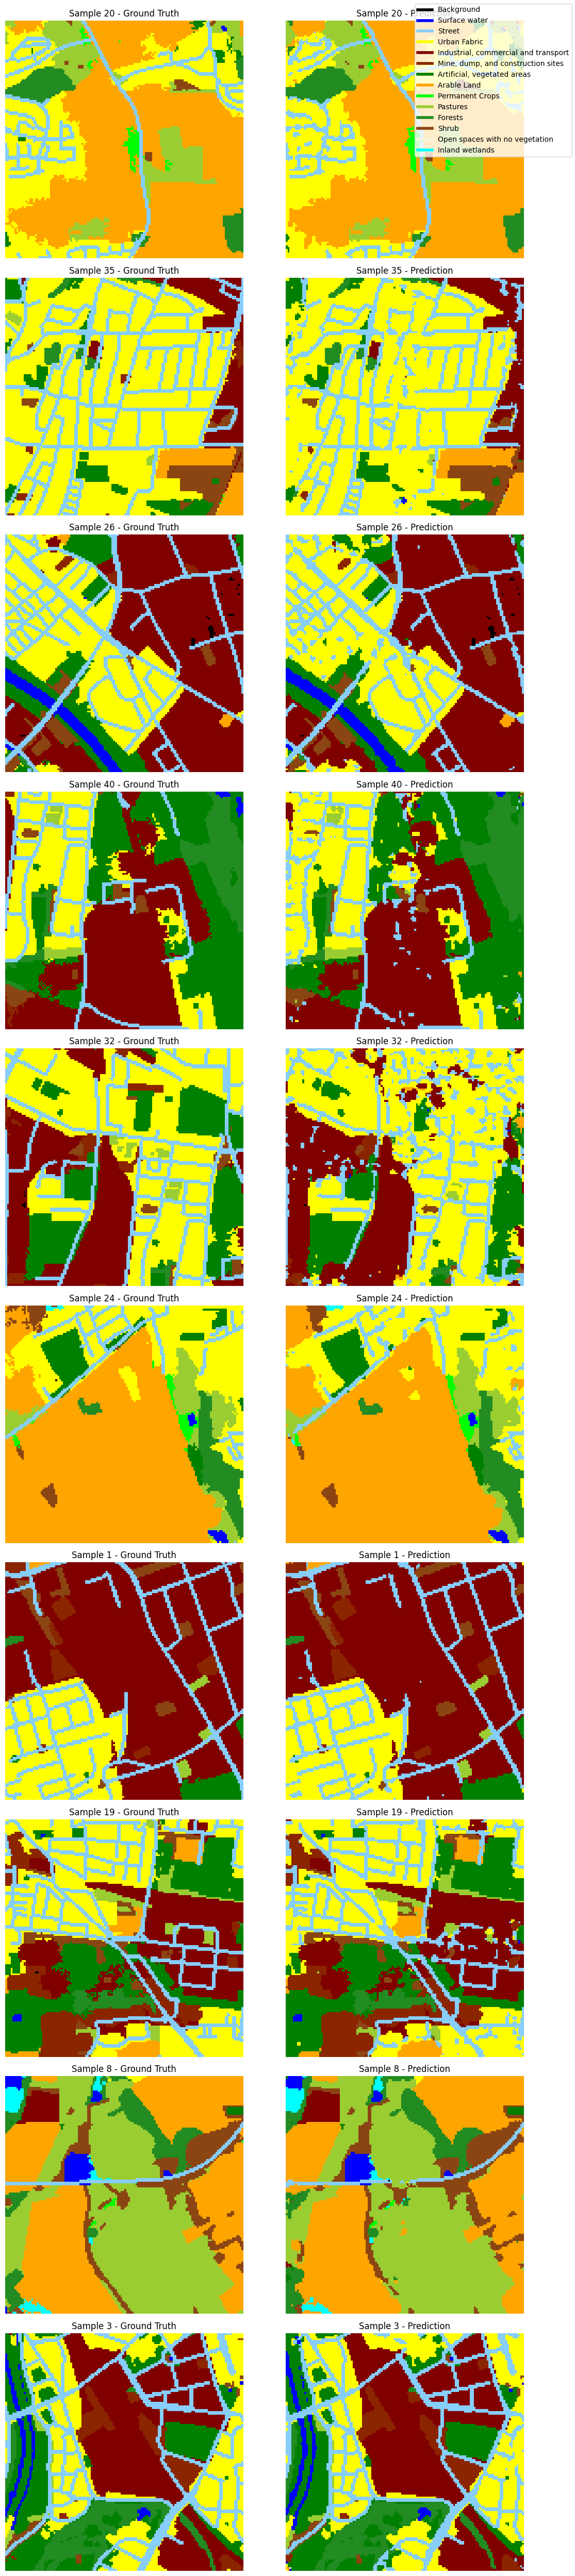

NameError: name 'train_losses' is not defined

In [8]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

visualize_predictions(model, test_loader.dataset, label_map, labels, device, num_samples=10)


In [9]:
import torch
torch.save(model.state_dict(), "best_model.pth")